<a href="https://colab.research.google.com/github/armandordorica/MIE1517_A1/blob/main/Assignment_1_Bonus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PART C (Optional) - Bonus Challenge!

This is an optional exercise for those that finish the assignment early and would like to perform a deeper exploration of the assignment.

In part A we constructed and trained a 2-layer neural network from scratch. In Part B we saw how PyTorch can be used to simplify the construction of neural networks by taking care of all the complexity related to gradient calculations, training on GPUs, and structuring your code.

For this bonus challenge we will propose additional task that will have you work towards completing the pipeline and deploying the models online, while exploring ways to improve these models along the way.

Tasks:

1. Modify your code to classify images that are not cars or trucks into the category "other".
2. Preprocess images from the internet to be able to classify any images into cars and trucks (i.e., resize, aspect ratio, etc.). Evaluate your best model's performance on images loaded from the internet.
3. Deploy your best model onto huggingface spaces (or other web hosting services) to classify images into cars, trucks, and "other" if you've completed task 1.

Bonus marks will be provided based on the number of tasks completed and how well they are completed. Summarize below your results and anything intersting you learned from the steps that you completed. Bonus marks cannot be accumulated beyond a maximum assignment grade.

### Retraining Model and ensuring inference on data from Internet (test set)

In [4]:
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/u of t/PhD/2023/MIE 1517 - Deep Learning/Assignments/A1'

Mounted at /content/drive


In [6]:
import os
folder_path = '/content/drive/MyDrive/u of t/PhD/2023/MIE 1517 - Deep Learning/Assignments/A1'
os.chdir(folder_path)

In [11]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms
from IPython.display import Image as ipythonimg, display
import matplotlib.image as mpimg

###############################################################################
# Data Loading


def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 9
        label_class = classes[label_index] # ex: 'truck'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cars and trucks, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()



def plot_multiple_training_curves(paths, labels):
    """
    Plots the training curve for multiple model runs, given the csv files
    containing the train/validation error/loss.

    Args:
        paths: List of base paths of the csv files produced during training
        labels: List of labels for each path for legend
    """

    plt.figure(figsize=(12, 6))
    plt.title("Train vs Validation Error")

    for path, label in zip(paths, labels):
        train_err = np.loadtxt("{}_train_err.csv".format(path))
        val_err = np.loadtxt("{}_val_err.csv".format(path))

        # Print the vectors
        print(f"Train Error for {label}: {train_err}")
        print(f"Validation Error for {label}: {val_err}")

        n = len(train_err)  # number of epochs
        plt.plot(range(1, n+1), train_err, label="Train " + label)
        plt.plot(range(1, n+1), val_err, linestyle='--', label="Validation " + label)

    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.title("Train vs Validation Loss")

    for path, label in zip(paths, labels):
        train_loss = np.loadtxt("{}_train_loss.csv".format(path))
        val_loss = np.loadtxt("{}_val_loss.csv".format(path))
        n = len(train_loss)  # number of epochs
        plt.plot(range(1, n+1), train_loss, label="Train " + label)
        plt.plot(range(1, n+1), val_loss, linestyle='--', label="Validation " + label)

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()



# Load the trained model
def load_model(epoch_num=49):
    model = LargeNet()
    model_path = get_model_name(model.name, batch_size=64, learning_rate=0.001, epoch=epoch_num)
    model.load_state_dict(torch.load(model_path))
    model.eval() # Set the model to evaluation mode
    return model

# Preprocess the image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Assuming CIFAR-10 normalization
    ])
    image = Image.open(image_path)
    return transform(image).unsqueeze(0) # Add batch dimension

# Inference
def predict(image_path, model):
    image = preprocess_image(image_path)
    output = model(image)
    prob = torch.sigmoid(output).item()
    if prob > 0.5:
        return "Truck", prob
    else:
        return "Car", prob

def display_image(image_path, width=5):
    """
    Display the image with a specified width.

    Parameters:
    - image_path (str): Path to the image.
    - width (float): Desired width of the displayed image in inches. Default is 5 inches.
    """
    img = mpimg.imread(image_path)
    plt.figure(figsize=(width, width*(img.shape[0]/img.shape[1])))  # Calculate height based on aspect ratio
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()


class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x


def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cars vs trucks
    target_classes = ["car", "truck"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        print("Model Path")
        print(model_path)
        torch.save(net.state_dict(), model_path)


        # net.save_pretrained(model_path+"_huggingface")
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    # print("Saving files like {}_train_err.csv".format(model_path))
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)


large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.001, num_epochs=50)
plot_multiple_training_curves(['model_large_bs64_lr0.001_epoch49'],  ["LR=0.001 batch size 64 Large - chosen architecture with many epochs"])

Files already downloaded and verified


KeyboardInterrupt: ignored

The image is predicted to be a Car with probability 0.13


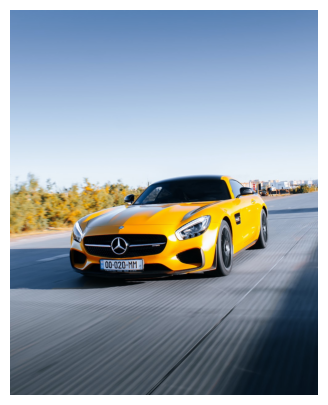

In [17]:



# os.chdir("/content/drive/MyDrive/u of t/PhD/2023/MIE 1517 - Deep Learning/Assignments/A1")
image_path = "/content/drive/MyDrive/u of t/PhD/2023/MIE 1517 - Deep Learning/Assignments/A1/test_images/car1.jpeg"

model = load_model()
prediction, probability = predict(image_path, model)

print(f"The image is predicted to be a {prediction} with probability {probability:.2f}")
display_image(image_path, width=4)  # Change the width value as needed

The image is predicted to be a Car with probability 0.07


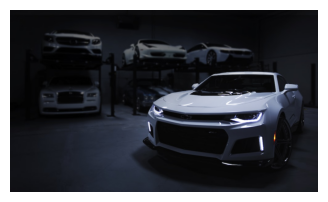

In [18]:
os.chdir("/content/drive/MyDrive/u of t/PhD/2023/MIE 1517 - Deep Learning/Assignments/A1")
image_path = "/content/drive/MyDrive/u of t/PhD/2023/MIE 1517 - Deep Learning/Assignments/A1/test_images/car2.jpeg"

model = load_model()
prediction, probability = predict(image_path, model)
print(f"The image is predicted to be a {prediction} with probability {probability:.2f}")
display_image(image_path, width=4)  # Change the width value as needed



The image is predicted to be a Truck with probability 0.96


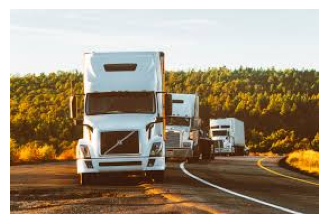

In [19]:
os.chdir("/content/drive/MyDrive/u of t/PhD/2023/MIE 1517 - Deep Learning/Assignments/A1")
image_path = "/content/drive/MyDrive/u of t/PhD/2023/MIE 1517 - Deep Learning/Assignments/A1/test_images/truck1.jpeg"

model = load_model()
prediction, probability = predict(image_path, model)
print(f"The image is predicted to be a {prediction} with probability {probability:.2f}")
display_image(image_path, width=4)  # Change the width value as needed


The image is predicted to be a Car with probability 0.09


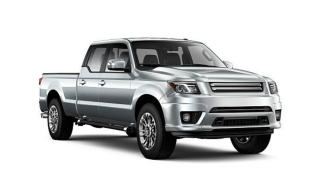

In [20]:
os.chdir("/content/drive/MyDrive/u of t/PhD/2023/MIE 1517 - Deep Learning/Assignments/A1")
image_path = "/content/drive/MyDrive/u of t/PhD/2023/MIE 1517 - Deep Learning/Assignments/A1/test_images/pickup1.jpg"

model = load_model()
prediction, probability = predict(image_path, model)
print(f"The image is predicted to be a {prediction} with probability {probability:.2f}")
display_image(image_path, width=4)  # Change the width value as needed


The image is predicted to be a Car with probability 0.34


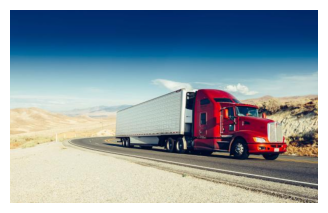

In [21]:
os.chdir("/content/drive/MyDrive/u of t/PhD/2023/MIE 1517 - Deep Learning/Assignments/A1")
image_path = "/content/drive/MyDrive/u of t/PhD/2023/MIE 1517 - Deep Learning/Assignments/A1/test_images/truck2.jpeg"

model = load_model()
prediction, probability = predict(image_path, model)
print(f"The image is predicted to be a {prediction} with probability {probability:.2f}")
display_image(image_path, width=4)  # Change the width value as needed


##  Modify your code to classify images that are not cars or trucks into the category "other".
### Retraining Model with 3 output neurons to be able to handle "other" case

1. I changed the output neurons in the fully connected layer to be equal to 3 as opposed to 2. In the previous version, we needed one output neuron as it was a binary classifier. Now, we use 3 since we're trying to predict between the classes car, truck, and other.

2. We change the loss function to be ```criterion = nn.CrossEntropyLoss()```

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.38075, Train loss: 0.6730399010181427 |Validation err: 0.3385, Validation loss: 0.6300515700131655
Epoch 2: Train err: 0.301375, Train loss: 0.5774398550987244 |Validation err: 0.285, Validation loss: 0.5510399080812931
Epoch 3: Train err: 0.24825, Train loss: 0.5083885214328766 |Validation err: 0.2265, Validation loss: 0.4807930886745453
Epoch 4: Train err: 0.21125, Train loss: 0.46211718702316285 |Validation err: 0.197, Validation loss: 0.4465349279344082
Epoch 5: Train err: 0.188875, Train loss: 0.42208970260620116 |Validation err: 0.1865, Validation loss: 0.4317637588828802
Epoch 6: Train err: 0.17675, Train loss: 0.40184451854228975 |Validation err: 0.1835, Validation loss: 0.4172625718638301
Epoch 7: Train err: 0.163625, Train loss: 0.3818161995410919 |Validation err: 0.1755, Validation loss: 0.4043710147961974
Epoch 8: Train err: 0.15875, Train loss: 0.36561273324489596 |Validation 

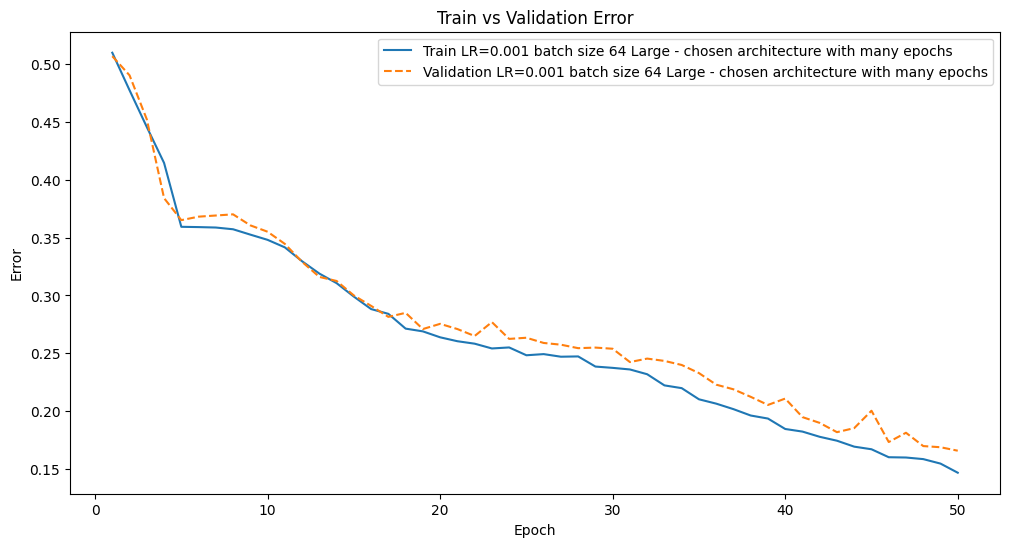

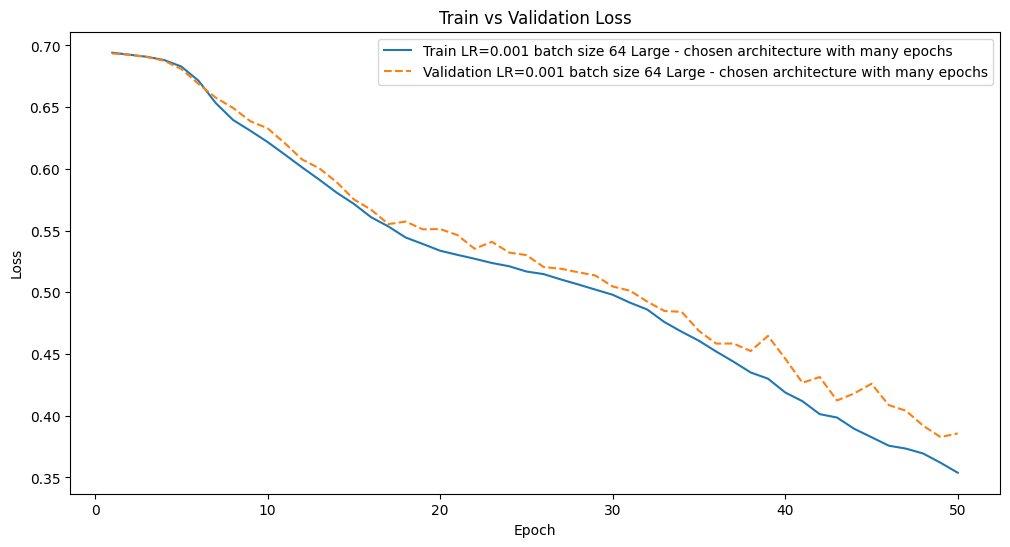

In [49]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
# Assuming that other necessary functions like get_data_loader, get_model_name,
# and plot_multiple_training_curves are available elsewhere in the code.

class LargeNet_multiclass(nn.Module):
    def __init__(self):
        super(LargeNet_multiclass, self).__init__()
        self.name = "LargeNet_multiclass"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def normalize_label(labels):
    new_labels = labels.clone()
    new_labels[labels == 1] = 0
    new_labels[labels == 9] = 1
    other_indices = (labels != 1) & (labels != 9)
    new_labels[other_indices] = 2
    return new_labels.long()

def evaluate(net, loader, criterion):
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        predicted = torch.argmax(outputs, 1)
        total_err += (predicted != labels).sum().item()
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    torch.manual_seed(1000)
    train_loader, val_loader, test_loader, classes = get_data_loader(
            ["car", "truck", "other"], batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    start_time = time.time()
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            labels = normalize_label(labels)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            predicted = torch.argmax(outputs, 1)
            total_train_err += (predicted != labels).sum().item()
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

large_net = LargeNet_multiclass()
train_net(large_net, batch_size=64, learning_rate=0.001, num_epochs=50)
plot_multiple_training_curves(['model_large_bs64_lr0.001_epoch49'],  ["LR=0.001 batch size 64 Large - chosen architecture with many epochs"])
